In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix

## READ

In [4]:
# Read Train and Test Data

X_train_scaled = pd.read_csv('data/X_train_scaled.csv')
X_test_scaled = pd.read_csv('data/X_test_scaled.csv')
y_train = pd.read_csv('data/y_train.csv').melt().value
y_test = pd.read_csv('data/y_test.csv').melt().value

## Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.8364336112892881
[[3015  696]
 [ 324 2201]]


## SVM

In [8]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 42)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.855516356638871
[[3046  665]
 [ 236 2289]]


## Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9209429121231558
[[3461  250]
 [ 243 2282]]


In [10]:
print('Number of nodes', dt.tree_.node_count)

Number of nodes 2025


In [11]:
from sklearn import tree

# Text representation of full tree
text_representation = tree.export_text(dt)
print(text_representation)

|--- feature_4 <= -0.03
|   |--- feature_6 <= -0.39
|   |   |--- feature_3 <= -1.36
|   |   |   |--- class: 1
|   |   |--- feature_3 >  -1.36
|   |   |   |--- feature_29 <= 0.54
|   |   |   |   |--- feature_3 <= -0.03
|   |   |   |   |   |--- feature_6 <= -1.00
|   |   |   |   |   |   |--- feature_5 <= -0.48
|   |   |   |   |   |   |   |--- feature_0 <= 1.16
|   |   |   |   |   |   |   |   |--- feature_4 <= -0.55
|   |   |   |   |   |   |   |   |   |--- feature_10 <= -1.72
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_10 >  -1.72
|   |   |   |   |   |   |   |   |   |   |--- feature_11 <= 1.57
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- feature_11 >  1.57
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |--- feature_4 >  -0.55
|   |   |   |   |   |   |   |   |   |--- feature_21 <= 1.72
|   |   |

In [10]:
# # Visualize the full tree via "plot_tree" function

# # First, re-size the figure via matplotlib(otherwise it will be too small)
# plt.figure(figsize=(15,10))

# # Then call plot_tree() function
# # the 'filled' option generates colors in the nodes
# tree.plot_tree(dt, filled=True);

In [12]:
y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)

print('Accuracy score of full tree on training data =', round(train_score*100,1), '%')
print('Accuracy score of full tree on testing data =', round(test_score*100,1), '%')

Accuracy score of full tree on training data = 100.0 %
Accuracy score of full tree on testing data = 92.1 %


In [19]:
from sklearn.model_selection import GridSearchCV

# We create lists of all the values we want to search over
# This is called 'creating a grid'
param_grid = {
    'max_depth': range(400, 600, 10),
    'min_samples_leaf': [1, 20, 50, 100, 200],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}

# Then, use the GridSearchCV function which combines gridsearch with
# K-fold cross validation (cv parameter)
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring = 'accuracy')
gridSearch.fit(X_train_scaled, y_train)

print('Best accuracy: ', gridSearch.best_score_)
print('Parameter values to achieve best accuracy: ', gridSearch.best_params_)

Best accuracy:  0.9130584192439862
Parameter values to achieve best accuracy:  {'max_depth': 530, 'min_impurity_decrease': 0, 'min_samples_leaf': 1}


In [13]:
# Retrieve all the 'unique' values of penalty alpha and the impurity score
# they generate, from the full tree. We will use the cost_complexity_pruning_path() function
# To retrieve the alpha values, we need to call the option 'ccp_alphas'
alphas = dt.cost_complexity_pruning_path(X_train_scaled, y_train).ccp_alphas
alphas.shape

(557,)

In [14]:
# Create a decision tree for each possible value of alpha, and store the
# trees in an array called 'clfs'

clfs = [] # this creates an empty array (placeholder)

# now loop through all the possible alphas
for i in alphas:
    my_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    my_clf.fit(X_train_scaled, y_train)
    clfs.append(my_clf) #this line adds to the fitted tree to the clfs[] array


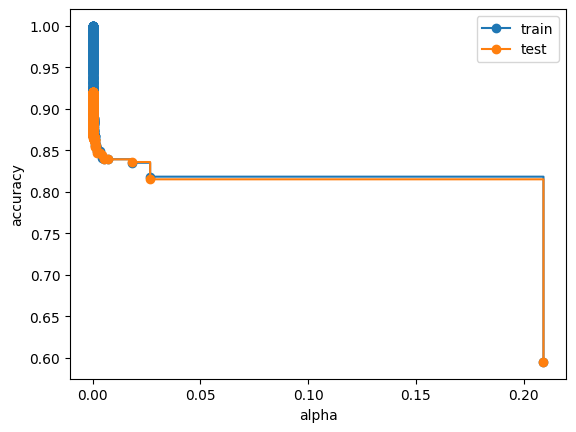

In [16]:
# Let's try to find the best alpha to use...
# We can plot the tree predictive accuracy as a function of alpha
train_scores = [accuracy_score(y_train, x.predict(X_train_scaled)) for x in clfs]
test_scores = [accuracy_score(y_test, x.predict(X_test_scaled)) for x in clfs]

# BTW, there is also an alternative function: score() that does the same thing
# train_scores = [x.score(X_train, y_train) for x in clfs]
# test_scores = [x.score(X_test, y_test) for x in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot(alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [17]:
accuracy_scores = cross_val_score(dt, X_train_scaled, y_train, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in accuracy_scores])
print('5-fold cross-validation mean accuracy:', round(accuracy_scores.mean(),3))

Accuracy scores of each fold:  ['0.919', '0.910', '0.912', '0.909', '0.912']
5-fold cross-validation mean accuracy: 0.912


## Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 2000, criterion = 'gini', min_samples_leaf = 1, random_state = 42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9485246953175113
[[3485  226]
 [  95 2430]]


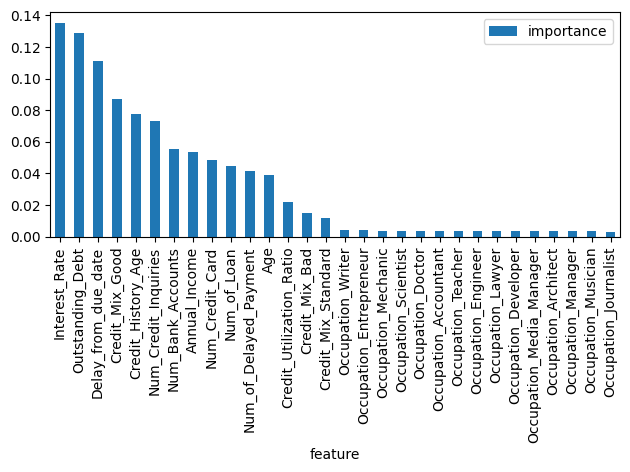

In [9]:
# Extract importance values for each feature (column of X)
importances = rf.feature_importances_

# create a dataframe to store the values and their labels
df2 = pd.DataFrame({'feature': X_train_scaled.columns, 'importance': importances})

# sort dataframe by descending order, showing the most important feature top
df2 = df2.sort_values('importance', ascending = False)

# plot the importance of each feature
ax = df2.plot(kind='bar', x='feature')

plt.tight_layout()
plt.show()